In [29]:
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2 as cv
import os
import matplotlib.pyplot as plt
from PIL import Image
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder

In [30]:
classes = os.listdir('E:\\Plant Doc Disease Classification\\PlantDoc-Dataset-master\\train')
tclasses = os.listdir('E:\\Plant Doc Disease Classification\\PlantDoc-Dataset-master\\test')
print(tclasses)

['Apple leaf', 'Apple rust leaf', 'Apple Scab Leaf', 'Bell_pepper leaf', 'Bell_pepper leaf spot', 'Blueberry leaf', 'Cherry leaf', 'Corn Gray leaf spot', 'Corn leaf blight', 'Corn rust leaf', 'grape leaf', 'grape leaf black rot', 'Peach leaf', 'Potato leaf early blight', 'Potato leaf late blight', 'Raspberry leaf', 'Soyabean leaf', 'Squash Powdery mildew leaf', 'Strawberry leaf', 'Tomato Early blight leaf', 'Tomato leaf', 'Tomato leaf bacterial spot', 'Tomato leaf late blight', 'Tomato leaf mosaic virus', 'Tomato leaf yellow virus', 'Tomato mold leaf', 'Tomato Septoria leaf spot', 'Tomato two spotted spider mites leaf']


In [37]:
def img_array(path):
    train_data = []
    labels = []
    for c in classes:
        path = path
        i = classes.index(c)
        #path = os.path.join(path,c)
        for img in os.listdir(os.path.join(path,c)):
            im = cv.imread(os.path.join(path,img))
            train_data.append(im)
            labels.append(c)
    train_data = np.array(train_data)
    labels = np.array(labels)
    return train_data, labels

train_rgb, train_lab_rgb = img_array(path = 'E:\\Plant Doc Disease Classification\\PlantDoc-Dataset-master\\train')
test_rgb, test_lab_rgb = img_array(path = 'E:\\Plant Doc Disease Classification\\PlantDoc-Dataset-master\\test')
train_lab, train_lab_lab = img_array(path = 'E:\\Plant Doc Disease Classification\\PlantDoc-Dataset-master\\gray_train')
test_lab, test_lab_lab = img_array(path = 'E:\\Plant Doc Disease Classification\\PlantDoc-Dataset-master\\gray_test')

In [42]:
train_rgb = train_rgb.astype('float32') / 255.0
train_lab = train_lab.astype('float32') / 255.0
test_rgb = test_rgb.astype('float32') / 255.0
test_lab = test_lab.astype('float32') / 255.0

In [38]:
lab = LabelEncoder()
encoded = lab.fit_transform(classes)
print(encoded)
train_lab_rgb = lab.fit_transform(train_lab_rgb)
test_lab_rgb = lab.fit_transform(test_lab_rgb)

[ 1  2  0  3  4  5  6  7  8  9 26 27 10 11 12 13 14 15 16 17 19 20 21 22
 23 24 18 25]


In [3]:
datagen = ImageDataGenerator(rescale=1./255)
gray_train_datagen = datagen.flow_from_directory('E:\\Plant Doc Disease Classification\\PlantDoc-Dataset-master\\gray_train',
                                            target_size = (128,128),
                                            batch_size = 64,
                                            class_mode = 'categorical')
gray_test_datagen = datagen.flow_from_directory('E:\\Plant Doc Disease Classification\\PlantDoc-Dataset-master\\gray_test',
                                            target_size = (128,128),
                                            batch_size = 64,
                                            class_mode = 'categorical')
train_datagen = datagen.flow_from_directory('E:\\Plant Doc Disease Classification\\PlantDoc-Dataset-master\\train',
                                            target_size = (128,128),
                                            batch_size = 64,
                                            class_mode = 'categorical')
test_datagen = datagen.flow_from_directory('E:\\Plant Doc Disease Classification\\PlantDoc-Dataset-master\\test',
                                            target_size = (128,128),
                                            batch_size = 64,
                                            class_mode = 'categorical')

Found 1960 images belonging to 28 classes.
Found 227 images belonging to 28 classes.
Found 1960 images belonging to 28 classes.
Found 227 images belonging to 28 classes.


In [33]:
rgb = tf.keras.layers.Input(shape=(128,128,3))
lab = tf.keras.layers.Input(shape=(128,128,3))

model1 = tf.keras.layers.Conv2D(32,kernel_size= (3,3), strides= (1,1), activation = 'relu')(rgb)
model1 = tf.keras.layers.MaxPooling2D((2,2))(model1)
model1 = tf.keras.layers.Conv2D(64,kernel_size= (3,3), strides= (1,1), activation = 'relu')(model1)
model1 = tf.keras.layers.MaxPooling2D((2,2))(model1)
out1 = tf.keras.layers.Flatten()(model1)
#model1 = tf.keras.Model(inputs = rgb, outputs = model1)

model2 = tf.keras.layers.Conv2D(32,kernel_size= (3,3), strides= (1,1), activation = 'relu')(lab)
model2 = tf.keras.layers.MaxPooling2D((2,2))(model2)
model2 = tf.keras.layers.Conv2D(64,kernel_size= (3,3), strides= (1,1), activation = 'relu')(model2)
model2 = tf.keras.layers.MaxPooling2D((2,2))(model2)
out2 = tf.keras.layers.Flatten()(model2)
#model2 = tf.keras.Model(inputs = lab, outputs = model2)

conc = tf.keras.layers.Concatenate()([out1, out2])

final = tf.keras.layers.Dense(128, activation= 'relu')(conc)
final = tf.keras.layers.Dense(len(classes), activation= 'softmax')(final)

model = tf.keras.Model(inputs = [rgb, lab], outputs = final)

model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_6 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 126, 126, 32  896         ['input_5[0][0]']                
                                )                                                           

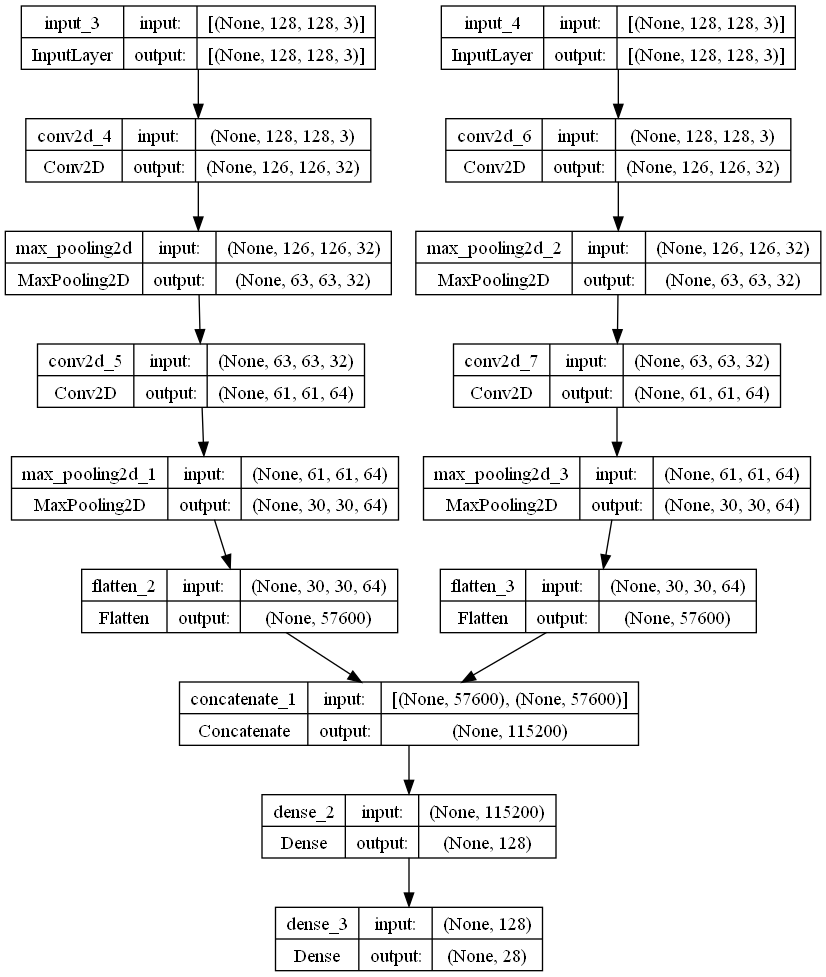

In [8]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [39]:
model.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics = ['Accuracy'])

In [40]:
labels = tf.keras.utils.to_categorical(encoded, len(classes))
train_leb = labels = tf.keras.utils.to_categorical(train_lab_rgb, len(classes))
test_leb = tf.keras.utils.to_categorical(test_lab_rgb, len(classes))

In [43]:
model.fit([train_rgb, train_lab], train_lab, epochs= 30, validation_data= ([test_rgb, test_lab], test_leb), verbose=1)

Epoch 1/30


ValueError: in user code:

    File "c:\Users\ASUS\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\keras\engine\training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\ASUS\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\keras\engine\training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\ASUS\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\keras\engine\training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\ASUS\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\keras\engine\training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\ASUS\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\ASUS\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\keras\engine\input_spec.py", line 253, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'model_2' (type Functional).
    
    Input 0 of layer "conv2d_10" is incompatible with the layer: expected min_ndim=4, found ndim=1. Full shape received: (None,)
    
    Call arguments received by layer 'model_2' (type Functional):
      • inputs=('tf.Tensor(shape=(None,), dtype=float32)', 'tf.Tensor(shape=(None,), dtype=float32)')
      • training=True
      • mask=None
